In [15]:
# Loading relevant libraries
import numpy as np
import os
from scipy import stats
from matplotlib  import pyplot as plt
import pyntbci

##### Loading preprocessed data

In [16]:
# root directory for extracted data
root_data = r"C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\SN_pilot_data\derivatives\pilot"

#loading: COVERT data
os.chdir(root_data)
tmp_covert = np.load("pilot_cvep_covert_mgold_61_6521_40T.npz")
X = tmp_covert["X"]
y = tmp_covert["y"]
V = tmp_covert["V"].T
fs = tmp_covert["fs"]
fr = 60

# For our experiment, we used only two classes. Hence, the flashing sequence matrix is limited to the first two codes in V.
V_needed = V[0:2,:]
V = V_needed

print("X", X.shape, "(trials x channels x samples)")  # EEG
print("y", y.shape, "(trials)")  # labels
print("V", V.shape, "(classes, samples)")  # codes
print("fs", fs, "Hz")  # sampling frequency
print("fr", fr, "Hz")  # presentation rate
print("trial duration was", X.shape[2]/fs,"s")


# Extract data dimensions
n_trials, n_channels, n_samples = X.shape
n_classes = V.shape[0]

# Read cap file
path = r"C:\Users\s1081686\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyntbci\capfiles" 
capfile = os.path.join(path, "biosemi32.loc")
with open(capfile, "r") as fid:
    channels = []
    for line in fid.readlines():
        channels.append(line.split("\t")[-1].strip())
print("Channels:", ", ".join(channels))

X (40, 32, 2520) (trials x channels x samples)
y (40,) (trials)
V (2, 504) (classes, samples)
fs 240 Hz
fr 60 Hz
trial duration was 10.5 s
Channels: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, O1, Oz, O2, PO4, P4, P8, CP6, CP2, C4, T8, FC6, FC2, F4, F8, AF4, Fp2, Fz, Cz


##### rCCA Decomposition for both classes separately

Shape of data after separation (20, 32, 2520) (trials x channels x samples)


C:\Users\s1081686\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


w:  (32, 1) (channels)
r:  (504, 1) (transient_size*events)
T: response templates for the chosen class (1, 2520) (n_classes x samples)


C:\Users\s1081686\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


w:  (32, 1) (channels)
r:  (504, 1) (transient_size*events)
T: response templates for the chosen class (1, 2520) (n_classes x samples)


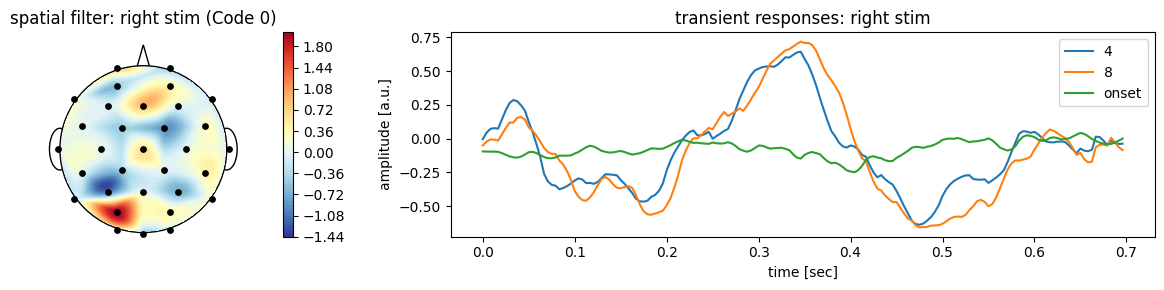

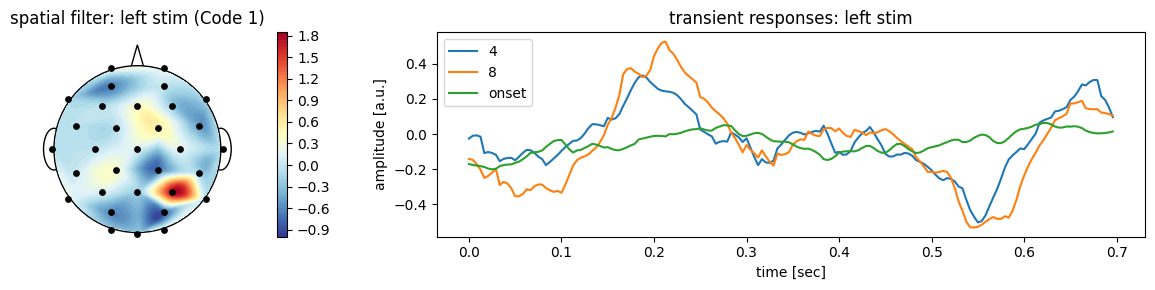

In [17]:
def rCCA_Decomp(X,y,codes, transient_size, plot, titles):

    """Parameters
        ----------
        X: np.ndarray
            The matrix of EEG data of shape (n_trials, n_channels, n_samples).
        y: np.ndarray
            The vector of ground-truth labels of the trials in X of shape (n_trials). Note, these denote the index at
            which to find the associated codes!
            
            **Note: In case you're computing spatial weights for just one class i.e. ONE code, make sure that y is a vector of zeros! 
            (Why?: y is used to access M indices like M[y,...], so if M is 1 x 504 vector, only M[0,..] is an accessible dimension. For this case, if y happens to be 1 then M[1,...] will give out an index error)
            For more details, check line ~= 780 in classifiers.py
            
        codes: np.ndarray
            Codes used for flashing the stimuli at certain frequencies
        
        transient_size: float
            The duration of the response template (check the plot for more details)
            
        plot: str
            Plot the spatial filter results and the transient responses      

    """
    rcca = pyntbci.classifiers.rCCA(codes=codes, fs=fs, event="duration", transient_size=transient_size, onset_event=True)
    rcca.fit(X, y) 
    
    # getting the templates
    T = rcca._get_T(n_samples=X.shape[2]) 
    print("w: ", rcca.w_.shape, "(channels)")
    print("r: ", rcca.r_.shape, "(transient_size*events)")
    print("T: response templates for the chosen class",T.shape,"(n_classes x samples)")

    # Plot CCA filters
    if plot == True:
        
        fig, ax = plt.subplots(1, 2, figsize=(15, 3))
        pyntbci.plotting.topoplot(rcca.w_, capfile, ax=ax[0],cbar = True)
        ax[0].set_title(titles[0])
        tmp = np.reshape(rcca.r_, (len(rcca.events_), -1))
        for i in range(len(rcca.events_)):
            ax[1].plot(np.arange(int(transient_size * fs)) / fs, tmp[i, :])
        ax[1].legend(rcca.events_)
        ax[1].set_xlabel("time [sec]")
        ax[1].set_ylabel("amplitude [a.u.]")
        ax[1].set_title(titles[1])
        fig.tight_layout()
        
    return rcca.w_,rcca.r_,T
        
# Separating EEG data based on codes/classes

# Data and codes for 'N'key/class appearing on the right
ind_0 = (y==0)
X_0 = X[ind_0,:,:] 
V_0 = V[0,:].reshape(1,504)

# # Data and codes for 'Y' key/class appearing on the left
ind_1 = (y==1)
X_1 = X[ind_1,:,:] 
V_1 = V[1,:].reshape(1,504)

# labels
y_ind=np.zeros((20,1))

print("Shape of data after separation",X_0.shape,"(trials x channels x samples)")   

# computing spatial filters and transient responses
w_0,_,T_0= rCCA_Decomp(X_0,y_ind,V_0,transient_size=0.7,plot=True,titles=["spatial filter: right stim (Code 0)","transient responses: right stim"])
w_1,_,T_1= rCCA_Decomp(X_1,y_ind,V_1,transient_size=0.7,plot=True,titles = ["spatial filter: left stim (Code 1)","transient responses: left stim"]) 

#### Computing correlations between spatial filters (W) and templates (T) explicitly

shape after filter application is (1, 50400) (1 x trials x samples)
dimension of corr matrix is: (20, 1) (num_trials x 1)


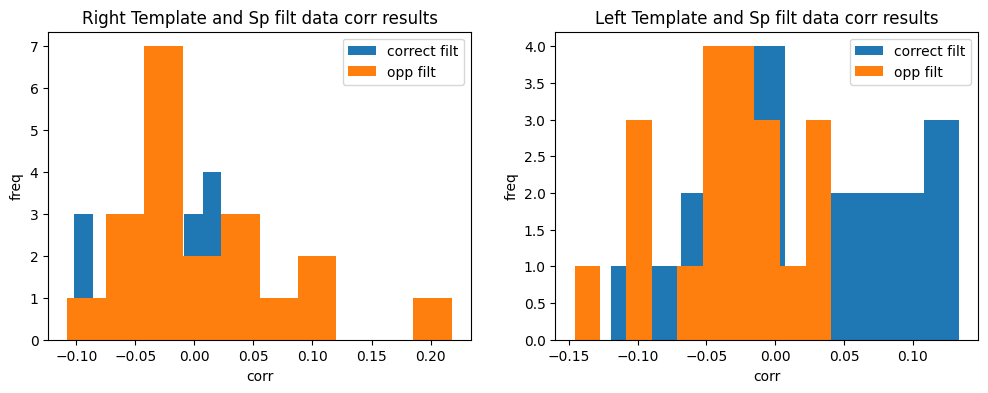

'amt of 1s and zeros in the code are usually balanced, check: b4 correlation, zscore the templates remove mean and var offsets'

In [21]:
'Preprocessing'
# reshaping data for the operation dot (w.T, X)
X_0_rs = X_0.reshape(X_0.shape[1],X_0.shape[0]*X_0.shape[2]) # channels x (trials x samples)
X_1_rs = X_1.reshape(X_1.shape[1],X_1.shape[0]*X_1.shape[2])

# Applying spatial filters to data sets (data class 0/1- filtered with w0/w1 respectively)
X_0_filt = np.dot(w_0.T,X_0_rs) # X0->w0
X_1_filt = np.dot(w_1.T,X_1_rs) # X1->w1

# Applying spatial filters to data sets (data class 0/1- filtered with w1/w0 respectively -- opposite class spatial filters)
X_0_filt_opp = np.dot(w_1.T,X_0_rs)# X0->w1
X_1_filt_opp = np.dot(w_0.T,X_1_rs)# X1->w0

print("shape after filter application is",X_0_filt.shape,"(1 x trials x samples)")

# Converting back to trials x samples format
X_0_filt = X_0_filt.reshape(X_0.shape[0],X_0.shape[2])
X_1_filt = X_1_filt.reshape(X_1.shape[0],X_1.shape[2])

# Converting back to trials x samples format(opposite filters)
X_0_filt_opp = X_0_filt_opp.reshape(X_0.shape[0],X_0.shape[2])
X_1_filt_opp = X_1_filt_opp.reshape(X_1.shape[0],X_1.shape[2])


'Finding Correlations'
#initialising correlation matrices for both sets of spatially filtered data
corr_0 = np.zeros((X_1_filt.shape[0],1))
corr_1 = np.zeros((X_1_filt.shape[0],1))
# opposite filters 
corr_0_opp = np.zeros((X_1_filt.shape[0],1))
corr_1_opp = np.zeros((X_1_filt.shape[0],1))

## Computing correlation between templates and spatial filters (the correlation function from utilities gives the same results)
for trial in range(X_0_filt.shape[0]):
    x_0_trial = X_0_filt[trial,:].flatten()
    x_1_trial = X_1_filt[trial,:].flatten()
    
    x_0_opp_trial = X_0_filt_opp[trial,:].flatten()
    x_1_opp_trial = X_1_filt_opp[trial,:].flatten()
    
    
    
    T_0 = T_0.flatten()
    T_1 = T_1.flatten()
    
    
    
    corr_0[trial],_ = stats.pearsonr(x_0_trial,T_0)
    corr_1[trial],_ = stats.pearsonr(x_1_trial,T_1)
    
    corr_0_opp[trial],_ = stats.pearsonr(x_0_opp_trial,T_0)
    corr_1_opp[trial],_ = stats.pearsonr(x_1_opp_trial,T_1)

print("dimension of corr matrix is:", corr_0.shape,"(num_trials x 1)")


'Plotting Results'
plt.figure(figsize = (12,4))
plt.subplot(121)
plt.hist(corr_0)
plt.hist(corr_0_opp)
plt.legend(['correct filt','opp filt'])
plt.xlabel("corr")
plt.ylabel('freq')
plt.title('Right Template and Sp filt data corr results')

plt.subplot(122)
plt.hist(corr_1)
plt.hist(corr_1_opp)
plt.legend(['correct filt','opp filt'])
plt.xlabel("corr")
plt.ylabel('freq')
plt.title('Left Template and Sp filt data corr results')
plt.show()


'compute histograms instead of line plot'
'amt of 1s and zeros in the code are usually balanced, check: b4 correlation, zscore the templates remove mean and var offsets'